OG PyTorch code by: Sriram Ravindran, sriram@ucsd.edu

Original paper - https://arxiv.org/abs/1611.08024

Please reach out to me if you spot an error.

# EEGNet core

In [1]:
# Boring ahh imports
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

# MNE stuff
import mne

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

#### Here's the description from the paper


<img src="EEGNet.png" style="width: 700px; float:left;">

#### the basic model + does it work?

we create an EEGNet class, with 2 arguments - channels, and samples. 
- first convolution kernel will have a width corresponding to the number of EEG channels/samples
- based on 'reshape value'- adjust fc1

In [2]:
class EEGNet(nn.Module):
    def __init__(self, channels, samples, verbose = False):
        super(EEGNet, self).__init__()

        self.kernellength = channels
        self.T = samples # AKA samples

        self.filter_sizing = 16

        self.verbose = verbose
        
        # Layer 1
        # input shape [n (?), kernel height, samples, kernel width]
        # corresponds [n (?), kern. h (=1)., time pts, kern w = channels]
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = self.filter_sizing, kernel_size = (1, self.kernellength), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(self.filter_sizing, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((self.filter_sizing, 17, 0, 1))
        self.conv2 = nn.Conv2d(in_channels = 1, out_channels = 4, kernel_size = (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)

        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(in_channels = 4, out_channels = 4, kernel_size = (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        self.fc1 = nn.Linear(152, 1)
        # NOTE: if error, sadly must recursively change the first value here to the "reshape value" in output

    def forward(self, x):
        # Layer 1
        if self.verbose:
            print("Layer 1 input:", x.shape)

        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = x.permute(0, 3, 1, 2)

        if self.verbose:
            print("Layer 1 output:", x.shape)

        # Layer 2
        if self.verbose:
            print("Layer 2 input:", x.shape)

        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)
        
        if self.verbose:
            print("Layer 2 output:", x.shape)

        # Layer 3
        if self.verbose:
            print("Layer 3 input:", x.shape)
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)
        if self.verbose:
            print("Layer 3 output:", x.shape, "layer 3 size: ", x.size)
            print(f"Size of x after pooling3: {x.shape}")
            print(f"reshape value: {x.shape[1]*x.shape[2]*x.shape[3]}")

        # FC Layer
        x = x.reshape(-1, x.shape[1]*x.shape[2]*x.shape[3])
        if self.verbose:
            print("FC Layer input:", x.shape)
            print(f"testing {self.fc1}")

        x = F.sigmoid(self.fc1(x))

        if self.verbose:
            print("FC Layer output:", x.shape)
        return x



In [3]:
# instantiate model + brief test, retro-fit reshape value if you change channels + samples
testkern = 62
testT = 300
testmodel = EEGNet(channels=testkern, samples=testT, verbose = True)
print (testmodel.forward(Variable(torch.Tensor(np.random.rand(32, 1, testT, testkern))))) # again, n, kern height, samples, kern width/EEG channels/electrodes

Layer 1 input: torch.Size([32, 1, 300, 62])
Layer 1 output: torch.Size([32, 1, 16, 300])
Layer 2 input: torch.Size([32, 1, 16, 300])
Layer 2 output: torch.Size([32, 4, 4, 76])
Layer 3 input: torch.Size([32, 4, 4, 76])
Layer 3 output: torch.Size([32, 4, 2, 19]) layer 3 size:  <built-in method size of Tensor object at 0x13b1dcb80>
Size of x after pooling3: torch.Size([32, 4, 2, 19])
reshape value: 152
FC Layer input: torch.Size([32, 152])
testing Linear(in_features=152, out_features=1, bias=True)
FC Layer output: torch.Size([32, 1])
tensor([[0.5291],
        [0.6061],
        [0.5287],
        [0.5945],
        [0.3888],
        [0.4573],
        [0.8155],
        [0.7208],
        [0.6696],
        [0.7286],
        [0.6603],
        [0.6683],
        [0.6579],
        [0.7231],
        [0.5141],
        [0.6477],
        [0.6098],
        [0.8208],
        [0.5975],
        [0.6939],
        [0.6374],
        [0.6447],
        [0.6076],
        [0.4907],
        [0.6625],
        [0.67

#### Evaluate function returns values of different criteria like accuracy, precision etc. 
In case you face memory overflow issues, use batch size to control how many samples get evaluated at one time. Use a batch_size that is a factor of length of samples. This ensures that you won't miss any samples.

In [4]:
def evaluate(net, batch_size, X, Y, params = ["acc"]):
    
    results = []
    predicted = []
    
    for i in range(len(X) // batch_size):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = Variable(torch.from_numpy(X[s:e]))
        pred = net(inputs)
        
        predicted.append(pred.data.cpu().numpy())
        
        
    inputs = Variable(torch.from_numpy(X))
    predicted = net(inputs)
    
    predicted = predicted.data.cpu().numpy()
    
    for param in params:
        if param == 'acc':
            results.append(accuracy_score(Y, np.round(predicted)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted))
        if param == "recall":
            results.append(recall_score(Y, np.round(predicted)))
        if param == "precision":
            results.append(precision_score(Y, np.round(predicted)))
        if param == "fmeasure":
            precision = precision_score(Y, np.round(predicted))
            recall = recall_score(Y, np.round(predicted))
            results.append(2*precision*recall/ (precision+recall))
    return results

#### Run

##### run method (same code, just packed into a method)

In [5]:
def run_net(net, batch_size, num_train_epochs, optimizer, criterion, X_train, y_train, X_val, y_val, X_test, y_test, title, plot = False):

    # batch_size = 32
    train_accuracy_scores = []
    val_accuracy_scores = []

    for epoch in range(num_train_epochs):  # loop over the dataset multiple times
        print ("\nEpoch ", epoch)
        
        running_loss = 0.0
        for i in range(len(X_train) // batch_size-1):
            s = i * batch_size
            e = i * batch_size+batch_size
            
            inputs = torch.from_numpy(X_train[s:e])
            labels = torch.FloatTensor(np.array([y_train[s:e]]).T * 1.0)
            
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            print(f"outputs.shape: {outputs.shape}")
            loss = criterion(outputs, labels)
            loss.backward()
            
            
            optimizer.step()
            
            # running_loss += loss.data[0]
            running_loss += loss.item()
        
        # Validation accuracy
        params = ["acc", "auc", "fmeasure"]
        print (params)
        print ("Training Loss ", running_loss)

        train_results = evaluate(net, batch_size, X_train, y_train, params)
        print ("Train - ", train_results)
        train_accuracy_scores.append(train_results[0])

        val_results = evaluate(net, batch_size, X_val, y_val, params)
        print ("Validation - ", val_results)
        val_accuracy_scores.append(val_results[0])

        test_results = evaluate(net, batch_size, X_test, y_test, params)
        print ("Test - ", test_results)
    
    if plot:
        plt.figure()

        plt.plot(range(num_train_epochs), train_accuracy_scores, label = 'train accuracy')
        plt.plot(range(num_train_epochs), val_accuracy_scores, label = 'val accuracy')

        plt.xlabel('epoch')
        plt.ylabel('accuracy')

        plt.legend()
        plt.title(f'accuracy vs. epoch {title}')
        plt.show()




clean way to import datasets? (tailored to MBT42)

In [6]:
def splitEEG_data(filepath, train_percent):
    eegfif = filepath
    epochs = mne.read_epochs(eegfif)
    events = mne.read_events(eegfif)

    labels = epochs.metadata['label'].values
    labels = labels - 1

    X = epochs.get_data().astype('float32')
    print(X.shape)
    # X = X.transpose((1, 0, 2, 3))
    X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2]) # 62 electrodes and 300 samples
    X = X.transpose(0, 1, 3, 2) # input shape of [n, 1, samples, channels]
    y = labels

    print(X.shape)
    print(y.shape)

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 1-train_percent, random_state = 42)
    X_val, X_test, y_val, y_test = train_test_split (X_temp, y_temp, test_size = 0.5, random_state = 42)

    return X_train, y_train, X_val, y_val, X_test, y_test


code to plot confusion matrix

In [7]:
def get_confusion_matrix(net, X_test, y_test):
    # Get the predictions on the test data
    inputs = torch.from_numpy(X_test)
    predicted = net(inputs)
    predicted = predicted.data.cpu().numpy()

    # Round the predictions to get binary values (0 or 1)
    preds = np.round(predicted)


    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, preds)
    print("conf matrix:")
    print(conf_matrix)


    classes = [0, 1]  # Assuming binary classification with class labels 0 and 1
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, values_format=".0f")

    plt.title("CONFUSION MATRIX")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

#### importing real data

Reading /Users/applelaptop/Desktop/MNE/data/S1_Session_1_3s_epochs.fif ...
Isotrak not found


/var/folders/3b/20z0s3dd3q153fvzct3hchb00000gn/T/ipykernel_63011/2057131345.py:3: RuntimeWarning: This filename (data/S1_Session_1_3s_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(eegfif)


    Found the data of interest:
        t =       0.00 ...    2990.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
125 matching events found
No baseline correction applied
0 projection items activated
(125, 62, 300)
(125, 1, 300, 62)
(125,)
Reading /Users/applelaptop/Desktop/MNE/data/S1_Session_2_3s_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    2990.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
125 matching events found
No baseline correction applied
0 projection items activated
(125, 62, 300)
(125, 1, 300, 62)
(125,)
Reading /Users/applelaptop/Desktop/MNE/data/S1_Session_3_3s_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    2990.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
125 matching events found
No baseline correction applied
0 projection items activated
(125, 62, 300)
(125, 1, 30

/var/folders/3b/20z0s3dd3q153fvzct3hchb00000gn/T/ipykernel_63011/2057131345.py:4: RuntimeWarning: This filename (data/S1_Session_1_3s_epochs.fif) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events = mne.read_events(eegfif)
/var/folders/3b/20z0s3dd3q153fvzct3hchb00000gn/T/ipykernel_63011/2057131345.py:3: RuntimeWarning: This filename (data/S1_Session_2_3s_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(eegfif)
/var/folders/3b/20z0s3dd3q153fvzct3hchb00000gn/T/ipykernel_63011/2057131345.py:4: RuntimeWarning: This filename (data/S1_Session_2_3s_epochs.fif) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  ev

['acc', 'auc', 'fmeasure']
Training Loss  2.9817973971366882


/var/folders/3b/20z0s3dd3q153fvzct3hchb00000gn/T/ipykernel_63011/2355648008.py:33: RuntimeWarning: invalid value encountered in double_scalars
  results.append(2*precision*recall/ (precision+recall))
/Users/applelaptop/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/3b/20z0s3dd3q153fvzct3hchb00000gn/T/ipykernel_63011/2355648008.py:33: RuntimeWarning: invalid value encountered in double_scalars
  results.append(2*precision*recall/ (precision+recall))
/Users/applelaptop/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

Train -  [0.49, 0.4028, nan]
Validation -  [0.4166666666666667, 0.7428571428571429, nan]
Test -  [0.6153846153846154, 0.45000000000000007, nan]

Epoch  1
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
['acc', 'auc', 'fmeasure']
Training Loss  2.2905394434928894
Train -  [0.51, 0.476, 0.3098591549295775]
Validation -  [0.5833333333333334, 0.9142857142857143, 0.4444444444444445]
Test -  [0.5384615384615384, 0.375, 0.25]

Epoch  2
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
['acc', 'auc', 'fmeasure']
Training Loss  2.109870195388794
Train -  [0.57, 0.5408, 0.6126126126126127]
Validation -  [0.5833333333333334, 0.7428571428571428, 0.5454545454545454]
Test -  [0.5384615384615384, 0.4, 0.5]

Epoch  3
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
['acc', 'auc', 'fmeasure']
Training Loss  2.1568326354026794
Train -  [0

/Users/applelaptop/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/3b/20z0s3dd3q153fvzct3hchb00000gn/T/ipykernel_63011/2355648008.py:33: RuntimeWarning: invalid value encountered in double_scalars
  results.append(2*precision*recall/ (precision+recall))
/var/folders/3b/20z0s3dd3q153fvzct3hchb00000gn/T/ipykernel_63011/2355648008.py:33: RuntimeWarning: invalid value encountered in double_scalars
  results.append(2*precision*recall/ (precision+recall))


Train -  [0.67, 0.8076, 0.547945205479452]
Validation -  [0.3333333333333333, 0.37142857142857144, nan]
Test -  [0.6153846153846154, 0.7, 0.4444444444444445]

Epoch  10
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])


/var/folders/3b/20z0s3dd3q153fvzct3hchb00000gn/T/ipykernel_63011/2355648008.py:33: RuntimeWarning: invalid value encountered in double_scalars
  results.append(2*precision*recall/ (precision+recall))


outputs.shape: torch.Size([25, 1])
['acc', 'auc', 'fmeasure']
Training Loss  1.5841722786426544
Train -  [0.78, 0.8972000000000001, 0.7380952380952381]
Validation -  [0.5, 0.6571428571428571, 0.4]
Test -  [0.7692307692307693, 0.8, 0.6666666666666665]

Epoch  11
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
['acc', 'auc', 'fmeasure']
Training Loss  1.4742397367954254
Train -  [0.84, 0.9272, 0.8222222222222222]
Validation -  [0.5, 0.6285714285714286, 0.5]
Test -  [0.6153846153846154, 0.675, 0.5454545454545454]

Epoch  12
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
['acc', 'auc', 'fmeasure']
Training Loss  1.3037523329257965
Train -  [0.91, 0.95, 0.9108910891089109]
Validation -  [0.6666666666666666, 0.6857142857142857, 0.6]
Test -  [0.8461538461538461, 0.95, 0.7499999999999999]

Epoch  13
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shap

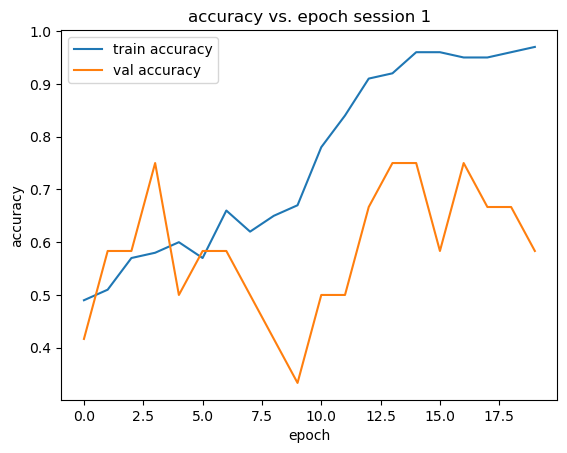


Epoch  0
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
['acc', 'auc', 'fmeasure']
Training Loss  0.7448515295982361
Train -  [0.8735632183908046, 0.9185185185185185, 0.8674698795180723]
Validation -  [0.9473684210526315, 1.0, 0.9473684210526316]
Test -  [0.8421052631578947, 0.9431818181818181, 0.823529411764706]

Epoch  1
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
['acc', 'auc', 'fmeasure']
Training Loss  0.7512432336807251
Train -  [0.8160919540229885, 0.9005291005291006, 0.8095238095238095]
Validation -  [0.9473684210526315, 1.0, 0.9473684210526316]
Test -  [0.8947368421052632, 0.9545454545454546, 0.875]

Epoch  2
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
['acc', 'auc', 'fmeasure']
Training Loss  0.6820769608020782
Train -  [0.8620689655172413, 0.9232804232804233, 0.8604651162790697]
Validation -  [0.9473684210526315, 1.0, 0.9473684210526316]
Test -  [0.8947368421052632, 0.9659090909090908, 0.875]

Epoch 

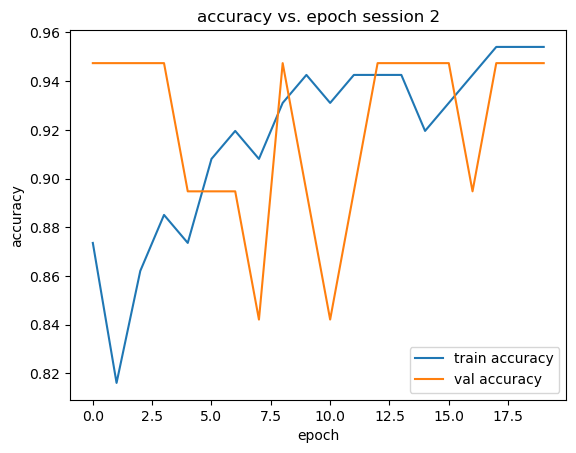

In [8]:
X_train_s1, y_train_s1, X_val_s1, y_val_s1, X_test_s1, y_test_s1 = splitEEG_data('data/S1_Session_1_3s_epochs.fif', 0.8)
X_train_s2, y_train_s2, X_val_s2, y_val_s2, X_test_s2, y_test_s2 = splitEEG_data('data/S1_Session_2_3s_epochs.fif', 0.7)
X_train_s3, y_train_s3, X_val_s3, y_val_s3, X_test_s3, y_test_s3 = splitEEG_data('data/S1_Session_3_3s_epochs.fif', 0.5)


# create model
model = EEGNet (62, 300)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

batch_size = 25
num_train_epochs = 20

# could do new models for each session or continue to train the model defined above, which I'm doing here:

run_net(model, batch_size, num_train_epochs, optimizer, criterion, X_train_s1, y_train_s1, X_val_s1, y_val_s1, X_test_s1, y_test_s1, 'session 1', plot = True)
run_net(model, batch_size, num_train_epochs, optimizer, criterion, X_train_s2, y_train_s2, X_val_s2, y_val_s2, X_test_s2, y_test_s2, 'session 2', plot = True)
# run_net(model, batch_size, num_train_epochs, optimizer, criterion, X_train_s3, y_train_s3, X_val_s3, y_val_s3, X_test_s3, y_test_s3, 'session 3', plot = True)

## Interpret

conf matrix:
[[15  4]
 [ 1 12]]


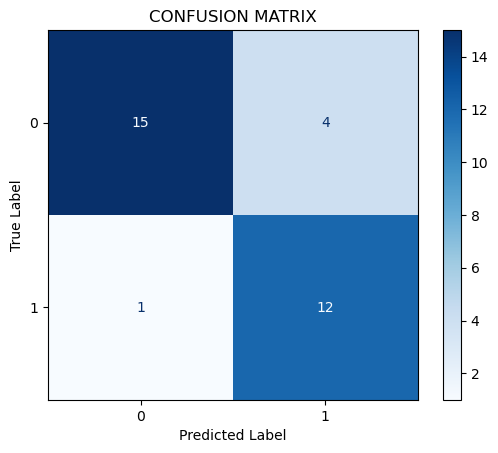

In [9]:
get_confusion_matrix(model, X_test_s3, y_test_s3)

In [10]:
eegfif = 'data/S1_Session_1_3s_epochs.fif'
epochs = mne.read_epochs(eegfif)
events = mne.read_events(eegfif)

print(epochs.metadata) # preproc question: what do the 1 and 2 refer to? left/right

Reading /Users/applelaptop/Desktop/MNE/data/S1_Session_1_3s_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    2990.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
125 matching events found
No baseline correction applied
0 projection items activated
     label  result  trial_too_short  has_noisy_chans      noisy_chans
0      1.0     0.0              0.0              1.0  [Fp1, Fpz, Fp2]
1      1.0     0.0              0.0              0.0               []
2      2.0     0.0              0.0              0.0               []
3      2.0     0.0              0.0              0.0               []
4      1.0     0.0              0.0              0.0               []
..     ...     ...              ...              ...              ...
120    2.0     0.0              0.0              0.0               []
121    1.0     0.0              0.0              0.0               []
122    2.0     0.0              1.0      

/var/folders/3b/20z0s3dd3q153fvzct3hchb00000gn/T/ipykernel_63011/894489819.py:2: RuntimeWarning: This filename (data/S1_Session_1_3s_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(eegfif)
/var/folders/3b/20z0s3dd3q153fvzct3hchb00000gn/T/ipykernel_63011/894489819.py:3: RuntimeWarning: This filename (data/S1_Session_1_3s_epochs.fif) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events = mne.read_events(eegfif)


In [11]:
assert False, "fjaglkjjflakjk"

AssertionError: fjaglkjjflakjk

# CHATGPT BREAKDOWN:


1. Importing Libraries: The code begins by importing various libraries used in the implementation, including NumPy, PyTorch, MNE (a library for EEG/MEG data analysis), and scikit-learn for machine learning tasks.

2. EEGNet Class Definition: The code defines a PyTorch neural network class called `EEGNet`. This class is responsible for building the architecture of the EEGNet model. The model architecture consists of three convolutional layers and one fully connected layer.

3. Forward Function: The `forward` function defines the forward pass of the neural network, which specifies how input data flows through the layers of the model. The function applies convolution, batch normalization, ELU activation, and dropout operations for each layer.

4. Instantiate the Model: After defining the `EEGNet` class, the code instantiates the model by creating an instance of the `EEGNet` class. The model is created with specific channel and sample dimensions (62 channels and 300 samples in this case).

5. Data Preprocessing: Next, the code reads EEG epochs and events data using the MNE library. The EEG data is then converted to a PyTorch tensor and preprocessed by normalizing the data to float32 format.

6. Train-Test Split: The EEG data is split into training, validation, and testing sets using the `train_test_split` function from scikit-learn.

7. Training the Model: The `run_net` function is responsible for training the EEGNet model. It performs a specified number of training epochs, optimizing the model's parameters using the Adam optimizer and minimizing the binary cross-entropy loss (BCELoss).

8. Evaluation: During training, the model's performance is evaluated on training, validation, and testing data after each epoch. The evaluation metrics used are accuracy, area under the ROC curve (AUC), and F1-score (fmeasure).

9. Running the Training: The `run_net` function is called with the training, validation, and testing data to train and evaluate the EEGNet model on the provided data.

Overall, the code performs the following steps:
- Defines the EEGNet model architecture using PyTorch.
- Reads EEG data and preprocesses it using MNE and NumPy.
- Splits the data into training, validation, and testing sets.
- Trains the EEGNet model on the training data and evaluates its performance on the validation and testing sets.

Keep in mind that this code seems to be designed for a binary classification problem (possibly for EEG-based classification of two classes). The code prints out the size of the tensor at various stages to help understand the shape of the data and tensors at each step of the process. It uses BCELoss as the loss function, which is suitable for binary classification tasks.

Please note that the evaluation metrics may vary depending on the specific problem and dataset.